In [1]:
import pandas as pd
import numpy as np
import torch

In [2]:
# multiDGD GO terms

# look at the dataframe with GO term analysis

go_df_1 = pd.read_csv('../../03_results/reports/sc_dgd_sae_go_analysis_small_2_biological_process.csv')
go_df_1['go type'] = 'biological process'
go_df2 = pd.read_csv('../../03_results/reports/sc_dgd_sae_go_analysis_large_2_biological_process.csv')
go_df2['go type'] = 'biological process'
go_df3 = pd.read_csv('../../03_results/reports/sc_dgd_sae_go_analysis_small_2_molecular_function.csv')
go_df3['go type'] = 'molecular function'
go_df4 = pd.read_csv('../../03_results/reports/sc_dgd_sae_go_analysis_large_2_molecular_function.csv')
go_df4['go type'] = 'molecular function'
go_df_dgd = pd.concat([go_df_1, go_df2, go_df3, go_df4], axis=0, ignore_index=True)
#go_df_dgd = go_df_dgd[(go_df_dgd['n_hits'] >= 1) & (go_df_dgd['mw_pval'] <= 0.01)]

In [3]:
activations_dgd = torch.load('../../03_results/reports/sae_model_10000_l1-1e-3_lr-1e-4_500epochs_activations.pt')

/tmp/ipykernel_209144/316332962.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  activations_dgd = torch.load('../../03_results/reports/sae_model_10000_l1-1e-3_lr-1e-4_50

In [4]:
# look at the dataframe with GO term analysis

go_df1 = pd.read_csv('../../03_results/reports/sc_enformer_sae_go_analysis_small_biological_process.csv')
go_df1['go type'] = 'biological process'
go_df2 = pd.read_csv('../../03_results/reports/sc_enformer_sae_go_analysis_large_biological_process.csv')
go_df2['go type'] = 'biological process'
go_df3 = pd.read_csv('../../03_results/reports/sc_enformer_sae_go_analysis_small_molecular_function.csv')
go_df3['go type'] = 'molecular function'
go_df4 = pd.read_csv('../../03_results/reports/sc_enformer_sae_go_analysis_large_molecular_function.csv')
go_df4['go type'] = 'molecular function'
go_df_geneformer = pd.concat([go_df1, go_df2, go_df3, go_df4], axis=0, ignore_index=True)
#go_df_geneformer = go_df_geneformer[(go_df_geneformer['n_hits'] >= 1) & (go_df_geneformer['mw_pval'] <= 0.01)]

In [5]:
activations_geneformer = torch.load('../../03_results/reports/sae_geneformer_10000_l1-1e-3_lr-1e-4_500epochs_activations.pt')

/tmp/ipykernel_209144/2534855289.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  activations_geneformer = torch.load('../../03_results/reports/sae_geneformer_10000_l1-1e

In [6]:
from goatools.obo_parser import GODag
obodag = GODag("../../01_data/go-basic.obo")

../../01_data/go-basic.obo: fmt(1.2) rel(2024-10-27) 44,017 Terms


### Compare what GO terms are included in both SAEs and embeddings

In [7]:
unique_go_terms_dgd = go_df_dgd['go_name'].unique()
unique_go_terms_geneformer = go_df_geneformer['go_name'].unique()

print(f"Number of unique GO terms in DGD: {len(unique_go_terms_dgd)}")
print(f"Number of unique GO terms in Geneformer: {len(unique_go_terms_geneformer)}")
print(f"Number of unique GO terms in DGD and Geneformer: {len(set(unique_go_terms_dgd) & set(unique_go_terms_geneformer))}")

Number of unique GO terms in DGD: 2499
Number of unique GO terms in Geneformer: 2596
Number of unique GO terms in DGD and Geneformer: 2499


### Paper figure

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import textwrap

/home/vschuste/miniconda3/envs/sc_mechinterp/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
def add_parent_go_terms(go_df):

    # for each go term, create a list of all parents
    go_terms = go_df['go_id'].unique()
    go_terms_ancestry = {}

    for go_term in go_terms:
        go_obj = obodag[go_term]
        level = go_obj.level
        out_parents = []
        out_levels = []
        while level > 1:
            parents = list(go_obj.parents)
            if len(parents) > 1:
                # get the parent with level-1
                for parent in parents:
                    if parent.level == level - 1:
                        go_obj = parent
                        break
            else:
                go_obj = parents[0]
            out_parents.append(go_obj.id)
            out_levels.append(go_obj.level)
            level = go_obj.level
        go_terms_ancestry[go_term] = {'parents': out_parents, 'levels': out_levels}

    parent_go_ids = []

    for go_term in go_terms_ancestry.keys():
        if len(go_terms_ancestry[go_term]['parents']) == 0:
            continue
        last_level = go_terms_ancestry[go_term]['levels'][-1]
        if last_level == 1:
            #print(go_terms_ancestry[go_term]['parents'])
            #print(go_terms_ancestry[go_term]['parents'][-1])
            parent_go_ids.append(go_terms_ancestry[go_term]['parents'][-1])

    parent_go_ids = list(set(parent_go_ids))

    go_df['parent_go_id_level1'] = go_df['go_id'].apply(lambda x: go_terms_ancestry[x]['parents'][-1] if len(go_terms_ancestry[x]['parents']) > 0 else x)
    go_df['parent_go_name_level1'] = go_df['parent_go_id_level1'].apply(lambda x: obodag[x].name)
    #go_df['parent_go_id_level2'] = go_df['go_id'].apply(lambda x: go_terms_ancestry[x]['parents'][-2] if len(go_terms_ancestry[x]['parents']) > 1 else x if len(go_terms_ancestry[x]['parents']) == 1 else '')
    go_df['parent_go_id_level2'] = go_df['go_id'].apply(lambda x: go_terms_ancestry[x]['parents'][-2] if len(go_terms_ancestry[x]['parents']) > 1 else x)
    go_df['parent_go_name_level2'] = go_df['parent_go_id_level2'].apply(lambda x: obodag[x].name if x != '' else '')
    #go_df['parent_go_id_level3'] = go_df['go_id'].apply(lambda x: go_terms_ancestry[x]['parents'][-3] if len(go_terms_ancestry[x]['parents']) > 2 else x if len(go_terms_ancestry[x]['parents']) == 2 else '')
    go_df['parent_go_id_level3'] = go_df['go_id'].apply(lambda x: go_terms_ancestry[x]['parents'][-3] if len(go_terms_ancestry[x]['parents']) > 2 else x)
    go_df['parent_go_name_level3'] = go_df['parent_go_id_level3'].apply(lambda x: obodag[x].name if x != '' else '')
    #go_df['parent_go_id_level4'] = go_df['go_id'].apply(lambda x: go_terms_ancestry[x]['parents'][-4] if len(go_terms_ancestry[x]['parents']) > 3 else x if len(go_terms_ancestry[x]['parents']) == 3 else '')
    go_df['parent_go_id_level4'] = go_df['go_id'].apply(lambda x: go_terms_ancestry[x]['parents'][-4] if len(go_terms_ancestry[x]['parents']) > 3 else x)
    go_df['parent_go_name_level4'] = go_df['parent_go_id_level4'].apply(lambda x: obodag[x].name if x != '' else '')

    go_df = go_df[(go_df['n_hits'] >= 1) & (go_df['mw_pval'] <= 0.01)]

    return go_df

go_df_dgd = add_parent_go_terms(go_df_dgd)
go_df_geneformer = add_parent_go_terms(go_df_geneformer)

In [10]:
go_feature_matrix_dgd = torch.zeros((len(go_df_dgd['go_name'].unique()), activations_dgd.shape[1]))
for i, go_id in enumerate(go_df_dgd['go_id'].unique()):
    for feat in go_df_dgd[go_df_dgd['go_id'] == go_id]['feature']:
        go_feature_matrix_dgd[i,feat] = 1
mtrx_go_ids_dgd = go_df_dgd['go_id'].unique()
mtrx_go_names_dgd = [obodag[x].name for x in mtrx_go_ids_dgd]
mtrx_feature_ids_dgd = torch.where(go_feature_matrix_dgd.sum(dim=0) > 0)[0]
go_feature_matrix_dgd = go_feature_matrix_dgd[:,torch.where(go_feature_matrix_dgd.sum(dim=0) > 0)[0]]

reducer = umap.UMAP(n_components=2, min_dist=0.5, n_neighbors=20, random_state=0, spread=10)
embedding = reducer.fit_transform(go_feature_matrix_dgd.T)
df_umap_dgd = pd.DataFrame(embedding, columns=['UMAP 1', 'UMAP 2'])
df_umap_dgd['feature'] = mtrx_feature_ids_dgd.numpy()

NameError: name 'umap' is not defined

In [ ]:
go_feature_matrix_geneformer = torch.zeros((len(go_df_geneformer['go_name'].unique()), activations_geneformer.shape[1]))
for i, go_id in enumerate(go_df_geneformer['go_id'].unique()):
    for feat in go_df_geneformer[go_df_geneformer['go_id'] == go_id]['feature']:
        go_feature_matrix_geneformer[i,feat] = 1
mtrx_go_ids_geneformer = go_df_geneformer['go_id'].unique()
mtrx_go_names_geneformer = [obodag[x].name for x in mtrx_go_ids_geneformer]
mtrx_feature_ids_geneformer = torch.where(go_feature_matrix_geneformer.sum(dim=0) > 0)[0]
go_feature_matrix_geneformer = go_feature_matrix_geneformer[:,torch.where(go_feature_matrix_geneformer.sum(dim=0) > 0)[0]]

reducer = umap.UMAP(n_components=2, min_dist=1.0, n_neighbors=10, random_state=0, spread=10)
embedding = reducer.fit_transform(go_feature_matrix_geneformer.T)
df_umap_geneformer = pd.DataFrame(embedding, columns=['UMAP 1', 'UMAP 2'])
df_umap_geneformer['feature'] = mtrx_feature_ids_geneformer.numpy()

/home/vschuste/miniconda3/envs/sc_mechinterp/lib/python3.9/site-packages/umap/umap_.py:1401: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/vschuste/miniconda3/envs/sc_mechinterp/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


/tmp/ipykernel_3514682/1935029377.py:49: UserWarning: 
The palette list has fewer values (16) than needed (23) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(data=df_umap_geneformer, x='UMAP 1', y='UMAP 2', hue='level_1_go_term', s=3, alpha=1, ec=None, palette=level1_palette, ax=ax_list[1])


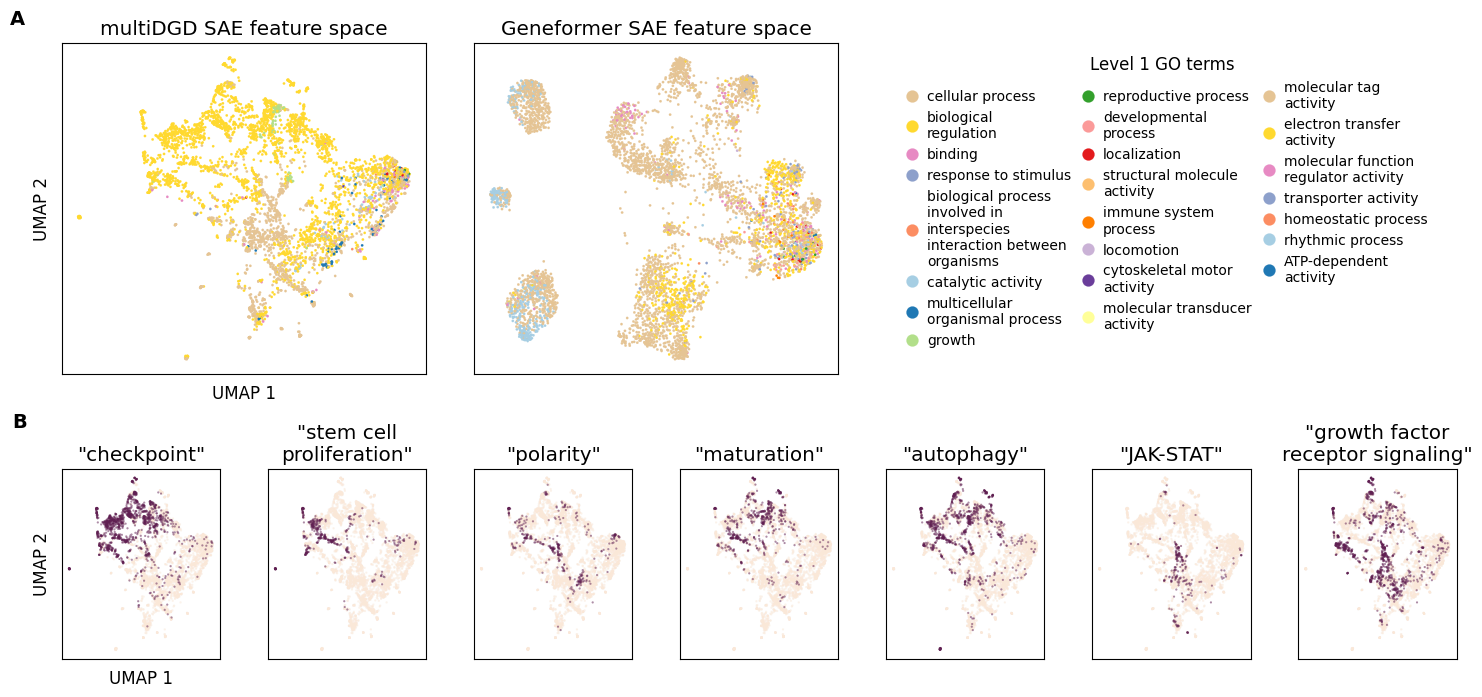

In [55]:
# create a nice grid plot with 6 columns and 4 rows

plt.rcParams.update({'font.size': 12})
n_cols = 7
n_rows = 5

legend_x = 0.3
legend_y = 1
handletextpad = 0.1
markerscale = 2

fig = plt.figure(figsize=(18, 8))
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(n_rows, n_cols, wspace=0.3, hspace=2)
ax_list = []

# next plot a umap colored by level1 go term
ax_list.append(plt.subplot(gs[0:3, 0:2]))
ax_list[0].text(-0.1, 1.1, 'A', transform=ax_list[0].transAxes, fontsize=14, fontweight='bold', va='top', ha='right')
# color each feature by its most prevalent level 1 go term
level_1_mtrx_terms = []
for feat in mtrx_feature_ids_dgd:
    feat = feat.item()
    temp_go_term = go_df_dgd[go_df_dgd['feature'] == feat]['parent_go_name_level1'].value_counts().index[0]
    level_1_mtrx_terms.append(temp_go_term)
df_umap_dgd['level_1_go_term'] = level_1_mtrx_terms
level1_paletteb = sns.color_palette('Paired')
level1_palettea = sns.color_palette('Set2_r')
level1_palettea = level1_palettea[:2] + level1_palettea[3:]
level1_palette = level1_palettea + level1_paletteb
level1_palette = level1_palette[:len(df_umap_dgd['level_1_go_term'].unique())]
sns.scatterplot(data=df_umap_dgd, x='UMAP 1', y='UMAP 2', hue='level_1_go_term', s=3, alpha=1, ec=None, palette=level1_palette, ax=ax_list[0])
ax_list[0].set_xticks([])
ax_list[0].set_yticks([])
ax_list[0].set_ylabel('UMAP 2')
ax_list[0].set_xlabel('UMAP 1')
ax_list[0].set_title('multiDGD SAE feature space')
ax_list[0].legend().remove()
# wrap the text for the legend


ax_list.append(plt.subplot(gs[0:3, 2:4]))
level_1_mtrx_terms = []
for feat in mtrx_feature_ids_geneformer:
    feat = feat.item()
    temp_go_term = go_df_geneformer[go_df_geneformer['feature'] == feat]['parent_go_name_level1'].value_counts().index[0]
    level_1_mtrx_terms.append(temp_go_term)
df_umap_geneformer['level_1_go_term'] = level_1_mtrx_terms
sns.scatterplot(data=df_umap_geneformer, x='UMAP 1', y='UMAP 2', hue='level_1_go_term', s=3, alpha=1, ec=None, palette=level1_palette, ax=ax_list[1])
ax_list[1].set_xticks([])
ax_list[1].set_yticks([])
ax_list[1].set_xlabel('')
ax_list[1].set_ylabel('')
ax_list[1].set_title('Geneformer SAE feature space')
handles, labels = ax_list[1].get_legend_handles_labels()
labels = [textwrap.fill(label, 20) for label in labels]
ax_list[1].legend(handles, labels, loc='upper right', bbox_to_anchor=(2.65, 1.0), frameon=False, handletextpad=handletextpad, markerscale=5, ncol=3, fontsize=10, columnspacing=0.2, title='Level 1 GO terms', title_fontsize='medium', labelspacing=0.5)

###
# probing
###
binary_colors = sns.color_palette('rocket_r', 100)
binary_colors = [binary_colors[0], binary_colors[75]]

probing_snippets = ['checkpoint', 'stem cell proliferation', 'polarity', 'maturation', 'autophagy', 'JAK-STAT', 'growth factor receptor signaling']
for i, term_snippet in enumerate(probing_snippets):
    ax_list.append(plt.subplot(gs[3:, i]))
    if i == 0:
        ax_list[-1].text(-0.22, 1.3, 'B', transform=ax_list[-1].transAxes, fontsize=14, fontweight='bold', va='top', ha='right')
    test_go_terms = np.asarray([1 if term_snippet in x else 0 for x in mtrx_go_names_dgd]).astype(bool)
    test_counts = go_feature_matrix_dgd[test_go_terms,:].clone().sum(dim=0).int()
    test_counts = (test_counts > 0).float()
    df_temp = df_umap_dgd.copy()
    df_temp[term_snippet] = test_counts.numpy()
    # sort the dataframe by the term snippet
    df_temp = df_temp.sort_values(by=term_snippet, ascending=True)
    sns.scatterplot(data=df_temp, x='UMAP 1', y='UMAP 2', hue=term_snippet, s=2, alpha=0.5, ec=None, palette=binary_colors, ax=ax_list[-1])
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    if i == 0:
        ax_list[-1].set_ylabel('UMAP 2')
        ax_list[-1].set_xlabel('UMAP 1')
    else:
        ax_list[-1].set_ylabel('')
        ax_list[-1].set_xlabel('')
    ax_list[-1].set_title('"{}"'.format(textwrap.fill(term_snippet, 20)))
    # remove the legend
    ax_list[-1].legend().remove()

# save as a pdf
plt.savefig('../../03_results/figures/sc_automatic_feature_analysis_3.png', bbox_inches='tight', dpi=300)
plt.show()

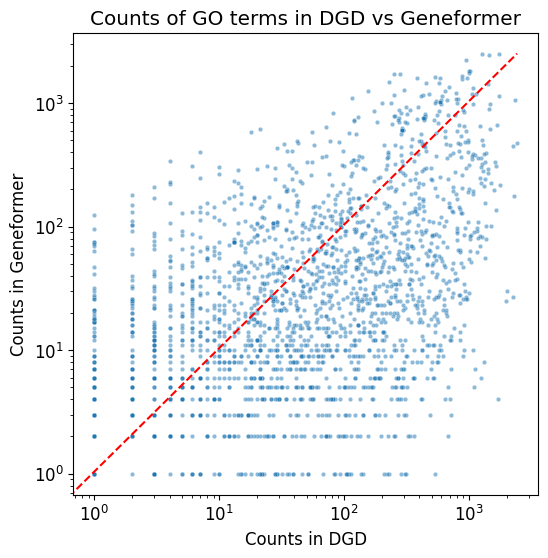

In [58]:
# plot the counts per go name of dgd against the counts per go name of geneformer
go_counts_dgd = go_df_dgd.value_counts('go_name').reset_index()
go_counts_dgd.columns = ['go_name', 'counts_dgd']
go_counts_geneformer = go_df_geneformer.value_counts('go_name').reset_index()
go_counts_geneformer.columns = ['go_name', 'counts_geneformer']
go_counts = pd.merge(go_counts_dgd, go_counts_geneformer, on='go_name', how='outer')
plt.figure(figsize=(6, 6))
sns.scatterplot(data=go_counts, x='counts_dgd', y='counts_geneformer', s=10, alpha=0.5)
plt.xlabel('Counts in DGD')
plt.ylabel('Counts in Geneformer')
plt.title('Counts of GO terms in DGD vs Geneformer')
plt.plot([0, go_counts['counts_dgd'].max()], [0, go_counts['counts_geneformer'].max()], color='red', linestyle='--')
#plt.xlim(0, go_counts['counts_dgd'].max())
#plt.ylim(0, go_counts['counts_geneformer'].max())
# logscale
plt.xscale('log')
plt.yscale('log')
#plt.savefig('../../03_results/figures/sc_automatic_feature_analysis_3_counts.png', bbox_inches='tight', dpi=300)
plt.show()

### Compare the binary feature matrices

In [13]:
go_feature_matrix_dgd = torch.zeros((len(go_df_dgd['go_name'].unique()), activations_dgd.shape[1]))
for i, go_id in enumerate(go_df_dgd['go_id'].unique()):
    for feat in go_df_dgd[go_df_dgd['go_id'] == go_id]['feature']:
        go_feature_matrix_dgd[i,feat] = 1
mtrx_go_ids_dgd = go_df_dgd['go_id'].unique()
mtrx_go_names_dgd = [obodag[x].name for x in mtrx_go_ids_dgd]
mtrx_feature_ids_dgd = torch.where(go_feature_matrix_dgd.sum(dim=0) > 0)[0]
go_feature_matrix_dgd = go_feature_matrix_dgd[:,torch.where(go_feature_matrix_dgd.sum(dim=0) > 0)[0]]

In [ ]:
# how many GO terms are in the feature matrix on average per feature?

avg_go_terms_per_feature_dgd = go_feature_matrix_dgd.sum(dim=0).mean().item()
# print the mean and SEM
print(f"Average number of GO terms per feature in DGD: {avg_go_terms_per_feature_dgd:.2f} ± {(go_feature_matrix_dgd.sum(dim=0).std().item()/go_feature_matrix_dgd.shape[0]**0.5):.2f} SEM")
# what are the min and max number of GO terms per feature?
min_go_terms_per_feature_dgd = go_feature_matrix_dgd.sum(dim=0).min().item()
max_go_terms_per_feature_dgd = go_feature_matrix_dgd.sum(dim=0).max().item()
print(f"Minimum number of GO terms per feature in DGD: {min_go_terms_per_feature_dgd}")
print(f"Maximum number of GO terms per feature in DGD: {max_go_terms_per_feature_dgd}")

Average number of GO terms per feature in DGD: 95.46 ± 1.72 SEM
Minimum number of GO terms per feature in DGD: 1.0
Maximum number of GO terms per feature in DGD: 482.0


In [17]:
go_feature_matrix_geneformer = torch.zeros((len(go_df_geneformer['go_name'].unique()), activations_geneformer.shape[1]))
for i, go_id in enumerate(go_df_geneformer['go_id'].unique()):
    for feat in go_df_geneformer[go_df_geneformer['go_id'] == go_id]['feature']:
        go_feature_matrix_geneformer[i,feat] = 1
mtrx_go_ids_geneformer = go_df_geneformer['go_id'].unique()
mtrx_go_names_geneformer = [obodag[x].name for x in mtrx_go_ids_geneformer]
mtrx_feature_ids_geneformer = torch.where(go_feature_matrix_geneformer.sum(dim=0) > 0)[0]
go_feature_matrix_geneformer = go_feature_matrix_geneformer[:,torch.where(go_feature_matrix_geneformer.sum(dim=0) > 0)[0]]

In [18]:
avg_go_terms_per_feature_geneformer = go_feature_matrix_geneformer.sum(dim=0).mean().item()
# print the mean and SEM
print(f"Average number of GO terms per feature in Geneformer: {avg_go_terms_per_feature_geneformer:.2f} ± {(go_feature_matrix_geneformer.sum(dim=0).std().item()/go_feature_matrix_geneformer.shape[0]**0.5):.2f} SEM")
# what are the min and max number of GO terms per feature?
min_go_terms_per_feature_geneformer = go_feature_matrix_geneformer.sum(dim=0).min().item()
max_go_terms_per_feature_geneformer = go_feature_matrix_geneformer.sum(dim=0).max().item()
print(f"Minimum number of GO terms per feature in Geneformer: {min_go_terms_per_feature_geneformer}")
print(f"Maximum number of GO terms per feature in Geneformer: {max_go_terms_per_feature_geneformer}")

Average number of GO terms per feature in Geneformer: 48.65 ± 0.98 SEM
Minimum number of GO terms per feature in Geneformer: 1.0
Maximum number of GO terms per feature in Geneformer: 254.0


In [31]:
# select the shared GO terms and sort the matrices by those
shared_go_terms = set(mtrx_go_names_dgd) & set(mtrx_go_names_geneformer)
shared_go_terms = sorted(shared_go_terms)
shared_go_ids = [x for x in mtrx_go_ids_dgd if obodag[x].name in shared_go_terms]
# get a translation of where the shared GO terms are in the matrices
shared_go_ids_dgd = [np.where(mtrx_go_ids_dgd == x)[0][0] for x in shared_go_ids]
shared_go_ids_geneformer = [np.where(mtrx_go_ids_geneformer == x)[0][0] for x in shared_go_ids]
go_feature_matrix_dgd_shared = go_feature_matrix_dgd[shared_go_ids_dgd,:].T
go_feature_matrix_geneformer_shared = go_feature_matrix_geneformer[shared_go_ids_geneformer,:].T
print(go_feature_matrix_dgd_shared.shape, go_feature_matrix_geneformer_shared.shape)

torch.Size([4374, 2499]) torch.Size([5290, 2499])


In [32]:
# compare with optimal bipartite matching
# since we have binary matrices, we can use the Jaccard index

from scipy.spatial.distance import jaccard
from scipy.optimize import linear_sum_assignment

def calculate_matrix_similarity(matrix_a: np.ndarray, matrix_b: np.ndarray) -> float:
    """
    Calculates the similarity between two binary matrices with shared columns
    but unsorted and unpaired rows.

    The method finds the optimal matching between rows of the two matrices
    using the Jaccard similarity and the Hungarian algorithm (linear_sum_assignment),
    and then computes the average similarity of these matched pairs.

    Args:
        matrix_a (np.ndarray): The first binary matrix with shape (n, k).
                               Rows are features/entities, columns are attributes.
        matrix_b (np.ndarray): The second binary matrix with shape (m, k).
                               Rows are features/entities, columns are attributes.
                               Must have the same number of columns (k) as matrix_a.

    Returns:
        float: A similarity score between 0.0 and 1.0.
               1.0 if both matrices are empty of rows.
               0.0 if one matrix is empty and the other is not.
    """
    n_rows_a, k_cols_a = matrix_a.shape
    n_rows_b, k_cols_b = matrix_b.shape

    if k_cols_a != k_cols_b:
        raise ValueError("Matrices must have the same number of columns (k).")

    # Handle edge cases with empty matrices
    if n_rows_a == 0 and n_rows_b == 0:
        return 1.0  # Two empty sets of rows can be considered perfectly similar
    if n_rows_a == 0 or n_rows_b == 0:
        return 0.0  # One empty and one non-empty matrix are not similar

    # 1. Calculate Jaccard Similarity for all pairs of rows
    # Similarity = 1 - Jaccard Distance
    # The similarity_matrix will have shape (n_rows_a, n_rows_b)
    similarity_matrix = np.zeros((n_rows_a, n_rows_b))

    for i in range(n_rows_a):
        for j in range(n_rows_b):
            row_a = matrix_a[i, :]
            row_b = matrix_b[j, :]
            # scipy.spatial.distance.jaccard computes the Jaccard *distance*
            # For boolean arrays, if both are all zeros, distance is 0 (similarity 1)
            # This is generally the desired behavior for identical all-zero patterns.
            # Ensure inputs are boolean for jaccard if they are int 0/1.
            # If they are already float 0.0/1.0, jaccard might treat them as continuous.
            # For binary (0/1) integer arrays, casting to bool is safest.
            try:
                j_distance = jaccard(row_a.astype(bool), row_b.astype(bool))
                similarity_matrix[i, j] = 1.0 - j_distance
            except ZeroDivisionError: 
                # This can happen if both rows are all zeros and the specific jaccard 
                # implementation doesn't gracefully handle 0/0.
                # Scipy's jaccard for boolean arrays should handle this (dist=0 if both all zero).
                # However, being explicit can be good.
                # If both rows sum to 0, they are identical in their emptiness.
                if np.sum(row_a) == 0 and np.sum(row_b) == 0:
                    similarity_matrix[i, j] = 1.0
                else:
                    similarity_matrix[i, j] = 0.0


    # 2. Construct the Cost Matrix for the assignment problem
    # The Hungarian algorithm (linear_sum_assignment) minimizes cost.
    # Cost = 1 - Similarity
    cost_matrix = 1.0 - similarity_matrix

    # 3. Solve the Assignment Problem
    # This finds the optimal pairing of rows from A to rows from B
    # (or vice-versa depending on which has fewer rows)
    # that minimizes the total cost.
    row_ind_a, col_ind_b = linear_sum_assignment(cost_matrix)

    # 4. Calculate the Overall Matrix Similarity
    # The number of matched pairs will be min(n_rows_a, n_rows_b)
    num_matched_pairs = len(row_ind_a)

    if num_matched_pairs == 0: # Should be covered by earlier checks, but as a safeguard
        return 0.0

    # Sum of similarities for the optimal matched pairs
    sum_optimal_similarities = similarity_matrix[row_ind_a, col_ind_b].sum()

    overall_similarity = sum_optimal_similarities / num_matched_pairs

    return overall_similarity

go_feature_similarity = calculate_matrix_similarity(go_feature_matrix_dgd_shared.numpy(), go_feature_matrix_geneformer_shared.numpy())

In [34]:
print(f"GO feature similarity (DGD to Geneformer): {go_feature_similarity:.4f}")

GO feature similarity (DGD to Geneformer): 0.1555


In [35]:
go_feature_similarity = calculate_matrix_similarity(go_feature_matrix_geneformer_shared.numpy(), go_feature_matrix_dgd_shared.numpy())
print(f"GO feature similarity (Geneformer to DGD): {go_feature_similarity:.4f}")

GO feature similarity (Geneformer to DGD): 0.1555
